In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st



c:\Users\adity\anaconda3\envs\myenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\adity\anaconda3\envs\myenv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


(-2.0, 2.0)

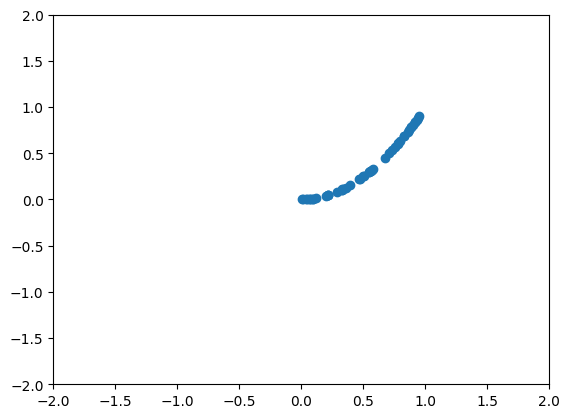

In [2]:
def manifold_func(x):
    return x**2

N_SAMPLES = 1000
x = torch.rand(size=(N_SAMPLES,))
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

fig, ax = plt.subplots()
ax.scatter(data[:50,0],data[:50,1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

In [3]:
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = data[idx]
        return data_item

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
dataset.data.shape

torch.Size([1000, 2])

In [5]:
def const_g(t,constant=0.1):
    return(t*0+constant)
def constant_f(x,t,const=1):

    return(x*0+const)

def counter_h(x_t,X_R=3):
    return(X_R-x_t)


In [6]:
def run_sde(x,
            f_determ_drift: Callable,    
            g_random_drift: Callable,
            h_random_drift: Callable,  #h(X_t,t)
            poisson_lamda: float,
            t_start: float = 0.0, 
            t_end: float = 1.0, 
            n_steps: int = 1000,
            **kwargs):
    """Function to run stochastic differential equation. We assume input data x-B*dim."""
    
    #Number of trajectories, dimension of data:
    n_traj,dim_x = x.shape

    #Compute time grid for discretization and step size:
    time_grid = np.linspace(t_start,t_end,n_steps)
    step_size = time_grid[1]-time_grid[0]

    #poisson jumps each of size 1
    print("final lamb",poisson_lamda*step_size)
    jump_occurred = np.random.poisson(lam=poisson_lamda*step_size, size=(n_steps,n_traj))>0
    jump_occurred=(torch.tensor(jump_occurred).unsqueeze(2)).numpy()

    #Compute the random drift at every time point:
    random_drift_grid = g_random_drift(time_grid)
    
    #Sample random drift at every time point:
    noise = np.random.normal(size=(n_steps,n_traj,dim_x))
    random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise
    
    #Initialize list of trajectory:
    x_traj = [x]
    
    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = float(time_grid[idx])
        
        #Get deterministic drift and random drift sample
        determ_drift = step_size*f_determ_drift(x,t)
        random_drift_sample = random_drift_grid_sample[idx]
        poisson_drift=h_random_drift(x)*jump_occurred[idx].astype(np.float64)
        
        #Compute next step:
        next_step = x + determ_drift + random_drift_sample + poisson_drift
        
        #Save step:
        x_traj.append(next_step)

    return np.stack(x_traj),time_grid    

In [7]:
f_drift=constant_f
g_drift=const_g
h_drift=counter_h
P_lambda=10
x_start=dataset.data
x_traj,time_grid = run_sde (x_start,f_drift,g_drift,h_drift,P_lambda)

final lamb 0.01001001001001001


0it [00:00, ?it/s]

In [8]:
x_traj.shape

(1001, 1000, 2)

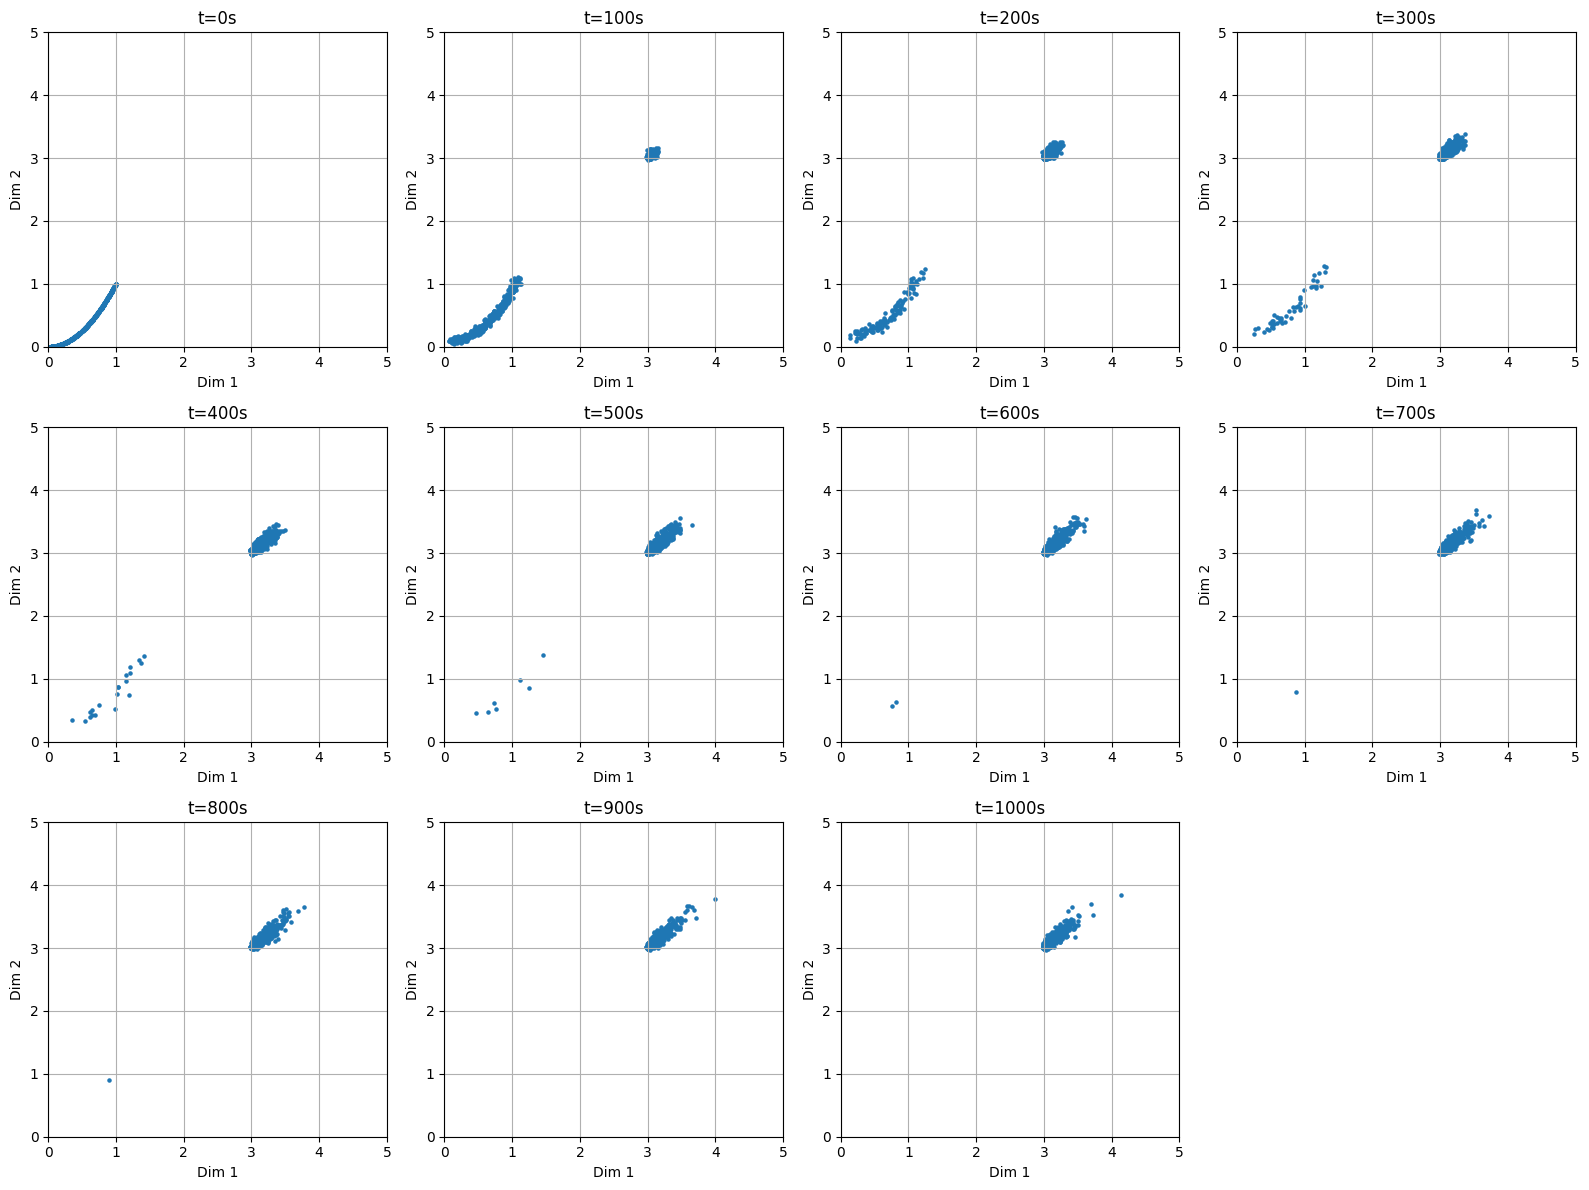

In [9]:
time_steps = list(range(0, x_traj.shape[0], 100))

# Create subplots (you can adjust layout based on number of plots)
n_plots = len(time_steps)
n_cols = 4
n_rows = -(-n_plots // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

for i, t in enumerate(time_steps):
    ax = axes[i]
    ax.scatter(x_traj[t, :, 0], x_traj[t, :, 1], s=5)
    ax.set_title(f"t={t}s")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 2, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim+1, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x, t):
        x_conc_t = torch.concat([x,t.unsqueeze(1)],axis=1)
        x = F.relu(self.input_batch_norm(self.input_layer(x_conc_t)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)

------------------------------
Generated 10000 samples using NumPy.
First 5 samples (NumPy method): [6.21833951 5.51938654 7.30275791 6.49032553 6.18785526]
Mean of samples: 6.3344


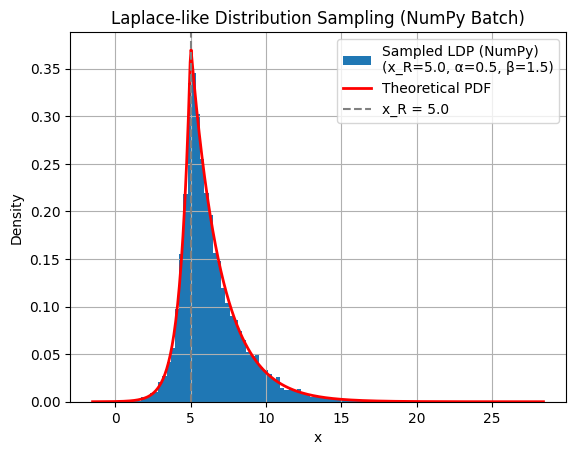

In [1]:
import numpy as np

def sample_batch_from_LDP_numpy(x_R, alpha, beta, num_samples):
    """
    Generates a batch of samples from the LDP distribution using NumPy for vectorization.

    Args:
        x_R: The mode of the distribution.
        alpha: The decay rate for the right tail (x >= x_R). Must be > 0.
        beta: The decay rate for the left tail (x <= x_R). Must be > 0.
        num_samples: The number of samples to generate in the batch.

    Returns:
        A NumPy array of `num_samples` from the distribution.
    """
    if alpha <= 0 or beta <= 0:
        raise ValueError("alpha and beta must be positive.")
    if num_samples <= 0:
        raise ValueError("num_samples must be positive.")

    # Probability of being in the left tail (x <= x_R)
    p_left = alpha / (alpha + beta)

    # Generate uniform random numbers
    u1_array = np.random.rand(num_samples)  # For choosing the tail
    u2_array = np.random.rand(num_samples)  # For generating the exponential variate
    
    # Ensure u2_array elements are not 0 to avoid log(0)
    # np.random.rand() produces [0.0, 1.0), so 0.0 is possible but very rare.
    # A practical way to handle this robustly for log:
    u2_array[u2_array == 0.0] = np.finfo(float).eps # Replace 0 with a very small positive number

    log_u2_array = np.log(u2_array)

    # Initialize samples array
    samples = np.empty(num_samples)

    # Boolean mask for left tail
    is_left_tail = u1_array <= p_left

    # Samples from the left tail
    samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta

    # Samples from the right tail (where not is_left_tail)
    is_right_tail = ~is_left_tail # Invert the mask
    samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
        
    return samples

# Example usage for NumPy version:
if __name__ == '__main__':
    print("-" * 30)
    x_R_val = 5.0
    alpha_val = 0.5
    beta_val = 1.5
    batch_size_np = 10000 # NumPy is better for larger batches

    batch_samples_np = sample_batch_from_LDP_numpy(x_R_val, alpha_val, beta_val, batch_size_np)
    print(f"Generated {batch_size_np} samples using NumPy.")
    print(f"First 5 samples (NumPy method): {batch_samples_np[:5]}")
    print(f"Mean of samples: {np.mean(batch_samples_np):.4f}") # Just for a quick check

    # Optional: Visualize the distribution of NumPy samples
    try:
        import matplotlib.pyplot as plt
        plt.figure() # Create a new figure if one was already shown
        plt.hist(batch_samples_np, bins=100, density=True, label=f'Sampled LDP (NumPy)\n(x_R={x_R_val}, α={alpha_val}, β={beta_val})')
        
        # Theoretical PDF for comparison (copied from previous response)
        x_vals = np.linspace(np.min(batch_samples_np) -1 , np.max(batch_samples_np) + 1, 500)
        pdf_vals = []
        C = (alpha_val * beta_val) / (alpha_val + beta_val)
        for x_v in x_vals:
            if x_v <= x_R_val:
                pdf_vals.append(C * np.exp(beta_val * (x_v - x_R_val)))
            else:
                pdf_vals.append(C * np.exp(-alpha_val * (x_v - x_R_val)))
        plt.plot(x_vals, pdf_vals, 'r-', lw=2, label='Theoretical PDF')
        plt.axvline(x_R_val, color='gray', linestyle='--', label=f'x_R = {x_R_val}')
        plt.title('Laplace-like Distribution Sampling (NumPy Batch)')
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    except ImportError:
        print("Matplotlib not installed. Skipping visualization for NumPy batch.")

Sampling 10000 values from the convolution f_N * f_LDP
Parameters for f_N: μ=0.1, t=2.0, σ=0.5
  => Normal(mean=0.20, std_dev=0.71)
Parameters for f_LDP: x_R=1.0, α=2.0, β=3.0

First 5 convolved samples: [0.0395638  2.20567878 2.17165685 2.58157891 0.60544391]
Mean of convolved samples: 1.3632
Expected mean of convolution: 1.0333


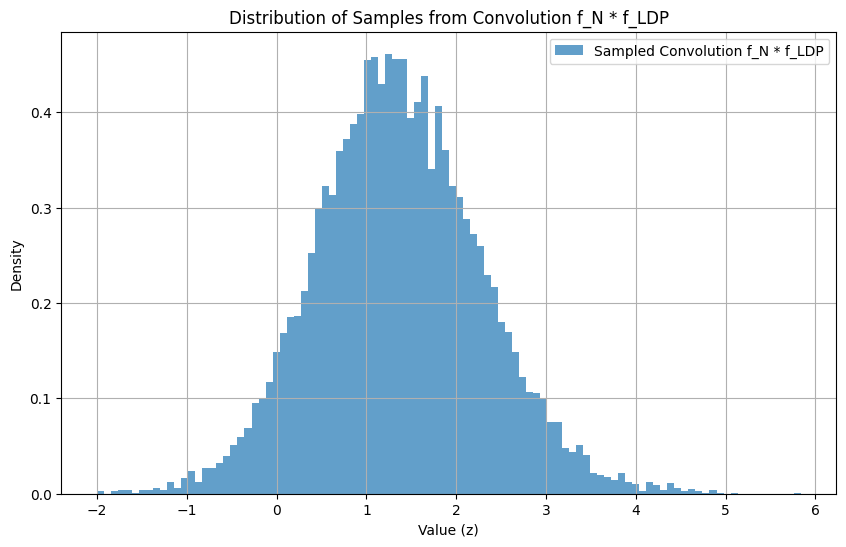

In [16]:
import numpy as np
import math # Only needed for the single LDP sampler if used directly

# --- Re-include the LDP batch sampler from previous response for completeness ---
def sample_batch_from_LDP_numpy(x_R, alpha, beta, num_samples):
    """
    Generates a batch of samples from the LDP distribution using NumPy for vectorization.
    (Assumes x_R, alpha, beta are scalars, num_samples is an int)
    """
    if alpha <= 0 or beta <= 0:
        raise ValueError("alpha and beta must be positive.")
    if num_samples <= 0:
        raise ValueError("num_samples must be positive.")

    p_left = alpha / (alpha + beta)
    u1_array = np.random.rand(num_samples)
    u2_array = np.random.rand(num_samples)
    u2_array[u2_array == 0.0] = np.finfo(float).eps # Avoid log(0)

    log_u2_array = np.log(u2_array)
    samples = np.empty(num_samples)
    is_left_tail = u1_array <= p_left

    samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta
    is_right_tail = ~is_left_tail
    samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
        
    return samples
# --- End of LDP sampler ---

def sample_batch_from_convolution(num_samples, 
                                  # Parameters for f_N
                                  mu_fN, t_fN, sigma_fN, 
                                  # Parameters for f_LDP
                                  x_R_LDP, alpha_LDP, beta_LDP):
    """
    Generates a batch of samples from the convolution f_N * f_LDP.

    Args:
        num_samples (int): The number of samples to generate.
        mu_fN (float): Parameter μ for the Normal distribution f_N.
        t_fN (float): Parameter t for the Normal distribution f_N. Must be > 0.
        sigma_fN (float): Parameter σ for the Normal distribution f_N. Must be > 0.
        x_R_LDP (float): Parameter x_R for the LDP distribution.
        alpha_LDP (float): Parameter α for the LDP distribution. Must be > 0.
        beta_LDP (float): Parameter β for the LDP distribution. Must be > 0.

    Returns:
        numpy.ndarray: An array of `num_samples` from the convolved distribution.
    """
    # if t_fN <= 0:
    #     raise ValueError("t_fN (for Normal distribution) must be positive.")
    # if sigma_fN <= 0:
    #     raise ValueError("sigma_fN (for Normal distribution) must be positive.")

    # 1. Sample from f_N (Normal distribution)
    mean_N = mu_fN * t_fN
    std_dev_N = sigma_fN * np.sqrt(t_fN)
    
    samples_N = np.random.normal(loc=mean_N, scale=std_dev_N, size=num_samples)

    # 2. Sample from f_LDP
    samples_LDP = sample_batch_from_LDP_numpy(x_R_LDP, alpha_LDP, beta_LDP, num_samples)

    # 3. The convolved sample is the sum of the independent samples
    convolved_samples = samples_N + samples_LDP
    
    return convolved_samples

# Example Usage:
if __name__ == '__main__':
    # Parameters for f_N
    param_mu_fN = 0.1      # Example value for μ in f_N
    param_t_fN = 2.0       # Example value for t in f_N
    param_sigma_fN = 0.5   # Example value for σ in f_N

    # Parameters for f_LDP
    param_x_R_LDP = 1.0    # Example value for x_R in f_LDP
    param_alpha_LDP = 2.0  # Example value for α in f_LDP
    param_beta_LDP = 3.0   # Example value for β in f_LDP
    
    batch_size = 10000

    print(f"Sampling {batch_size} values from the convolution f_N * f_LDP")
    print(f"Parameters for f_N: μ={param_mu_fN}, t={param_t_fN}, σ={param_sigma_fN}")
    print(f"  => Normal(mean={param_mu_fN*param_t_fN:.2f}, std_dev={param_sigma_fN*np.sqrt(param_t_fN):.2f})")
    print(f"Parameters for f_LDP: x_R={param_x_R_LDP}, α={param_alpha_LDP}, β={param_beta_LDP}")

    convolved_batch = sample_batch_from_convolution(
        num_samples=batch_size,
        mu_fN=param_mu_fN, t_fN=param_t_fN, sigma_fN=param_sigma_fN,
        x_R_LDP=param_x_R_LDP, alpha_LDP=param_alpha_LDP, beta_LDP=param_beta_LDP
    )

    print(f"\nFirst 5 convolved samples: {convolved_batch[:5]}")
    print(f"Mean of convolved samples: {np.mean(convolved_batch):.4f}")
    
    # Expected mean of convolution = mean_N + mean_LDP
    # Mean of LDP is x_R + (1/β) - (1/α)
    expected_mean_N = param_mu_fN * param_t_fN
    expected_mean_LDP = param_x_R_LDP + (1/param_beta_LDP) - (1/param_alpha_LDP)
    expected_mean_conv = expected_mean_N + expected_mean_LDP
    print(f"Expected mean of convolution: {expected_mean_conv:.4f}")


    # Optional: Visualize the distribution of convolved samples
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.hist(convolved_batch, bins=100, density=True, alpha=0.7, label=f'Sampled Convolution f_N * f_LDP')
        
        # For comparison, also plot the individual component distributions (shifted for clarity if needed)
        # samples_N_for_plot = np.random.normal(loc=expected_mean_N, scale=param_sigma_fN * np.sqrt(param_t_fN), size=batch_size)
        # samples_LDP_for_plot = sample_batch_from_LDP_numpy(param_x_R_LDP, param_alpha_LDP, param_beta_LDP, batch_size)
        # plt.hist(samples_N_for_plot, bins=100, density=True, alpha=0.5, label=f'f_N samples (mean={expected_mean_N:.2f})')
        # plt.hist(samples_LDP_for_plot, bins=100, density=True, alpha=0.5, label=f'f_LDP samples (mean={expected_mean_LDP:.2f})')

        plt.title('Distribution of Samples from Convolution f_N * f_LDP')
        plt.xlabel('Value (z)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    except ImportError:
        print("Matplotlib not installed. Skipping visualization.")

(20000,) (20000,)
(20000,) (20000,)


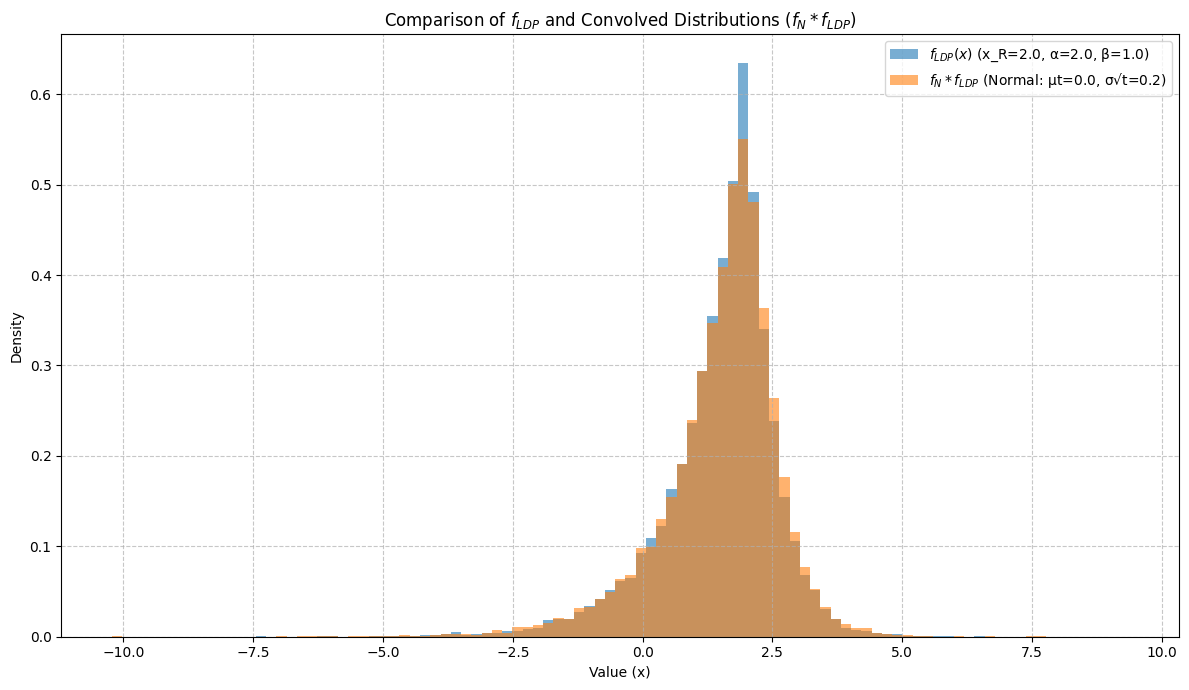

--- Statistics for f_LDP (direct) ---
Mean: 1.495, Std Dev: 1.109

--- Statistics for Convolution (Scenario 1: Normal(mean=0.00, std=0.18)) ---
Mean: 1.497, Std Dev: 1.156

--- Statistics for Convolution (Scenario 2: Normal(mean=0.50, std=1.00)) ---
Mean: 1.994, Std Dev: 1.501

Expected mean of LDP: 2.500
Expected mean of Conv1: 2.500
Expected mean of Conv2: 3.000


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math # Only for the single LDP sampler if used directly, not strictly needed here

# --- Re-include the LDP batch sampler ---
def sample_batch_from_LDP_numpy(x_R, alpha, beta, num_samples):
    if alpha <= 0 or beta <= 0:
        raise ValueError("alpha and beta must be positive.")
    if num_samples <= 0:
        raise ValueError("num_samples must be positive.")
    p_left = alpha / (alpha + beta)
    u1_array = np.random.rand(num_samples)
    u2_array = np.random.rand(num_samples)
    u2_array[u2_array == 0.0] = np.finfo(float).eps
    log_u2_array = np.log(u2_array)
    samples = np.empty(num_samples)
    is_left_tail = u1_array <= p_left
    samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta
    is_right_tail = ~is_left_tail
    samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
    return samples

# --- Re-include the convolution batch sampler ---
def sample_batch_from_convolution(num_samples, 
                                  mu_fN, t_fN, sigma_fN, 
                                  x_R_LDP, alpha_LDP, beta_LDP):
    # if t_fN <= 0:
    #     raise ValueError("t_fN (for Normal distribution) must be positive.")
    if sigma_fN <= 0:
        raise ValueError("sigma_fN (for Normal distribution) must be positive.")
    mean_N = mu_fN * t_fN
    std_dev_N = sigma_fN * np.sqrt(t_fN)
    samples_N = np.random.normal(loc=mean_N, scale=std_dev_N, size=num_samples)
    samples_LDP_component = sample_batch_from_LDP_numpy(x_R_LDP, alpha_LDP, beta_LDP, num_samples)
    print(samples_N.shape,samples_LDP_component.shape)
    convolved_samples = samples_N + samples_LDP_component
    return convolved_samples

# --- Main plotting script ---
if __name__ == '__main__':
    # Define common parameters
    batch_size = 20000 # Use a larger batch size for smoother histograms

    # Parameters for f_LDP (will be used for both direct sampling and as part of convolution)
    param_x_R_LDP = 2.0
    param_alpha_LDP = 2.0  # Controls right tail decay
    param_beta_LDP = 1.0   # Controls left tail decay

    # Parameters for f_N (the Normal distribution to convolve with f_LDP)
    # Let's try a few scenarios for f_N to see its effect
    
    # Scenario 1: Narrow Normal distribution (small smoothing effect)
    param_mu_fN_1 = 0
    param_t_fN_1 = 0.8
    param_sigma_fN_1 = 0.2  # Results in std_dev_N = 0.2 * sqrt(1) = 0.2

    # Scenario 2: Wider Normal distribution (larger smoothing effect)
    param_mu_fN_2 = 0.5 # Introduce a slight shift as well
    param_t_fN_2 = 1.0
    param_sigma_fN_2 = 1.0  # Results in std_dev_N = 1.0 * sqrt(1) = 1.0

    # --- Generate samples ---

    # 1. Samples from f_LDP directly
    samples_ldp_direct = sample_batch_from_LDP_numpy(
        param_x_R_LDP, param_alpha_LDP, param_beta_LDP, batch_size
    )

    # 2. Samples from convolution (Scenario 1)
    samples_convolved_1 = sample_batch_from_convolution(
        num_samples=batch_size,
        mu_fN=param_mu_fN_1, t_fN=param_t_fN_1, sigma_fN=param_sigma_fN_1,
        x_R_LDP=param_x_R_LDP, alpha_LDP=param_alpha_LDP, beta_LDP=param_beta_LDP
    )
    
    # 3. Samples from convolution (Scenario 2)
    samples_convolved_2 = sample_batch_from_convolution(
        num_samples=batch_size,
        mu_fN=param_mu_fN_2, t_fN=param_t_fN_2, sigma_fN=param_sigma_fN_2,
        x_R_LDP=param_x_R_LDP, alpha_LDP=param_alpha_LDP, beta_LDP=param_beta_LDP
    )

    # --- Plotting ---
    plt.figure(figsize=(12, 7))
    
    # Determine common bin range for all histograms for better comparison
    all_samples = np.concatenate([samples_ldp_direct, samples_convolved_1, samples_convolved_2])
    min_val = np.min(all_samples)
    max_val = np.max(all_samples)
    bins = np.linspace(min_val, max_val, 100) # 100 bins, or adjust as needed

    # Plot histogram for f_LDP
    plt.hist(samples_ldp_direct, bins=bins, density=True, alpha=0.6, 
             label=f'$f_{{LDP}}(x)$ (x_R={param_x_R_LDP}, α={param_alpha_LDP}, β={param_beta_LDP})')

    # Plot histogram for convolution Scenario 1
    label_conv1 = (f'$f_N * f_{{LDP}}$ (Normal: μt={param_mu_fN_1*param_t_fN_1:.1f}, '
                   f'σ√t={param_sigma_fN_1*np.sqrt(param_t_fN_1):.1f})')
    plt.hist(samples_convolved_1, bins=bins, density=True, alpha=0.6, 
             label=label_conv1)

    # Plot histogram for convolution Scenario 2
    # label_conv2 = (f'$f_N * f_{{LDP}}$ (Normal: μt={param_mu_fN_2*param_t_fN_2:.1f}, '
    #                f'σ√t={param_sigma_fN_2*np.sqrt(param_t_fN_2):.1f})')
    # plt.hist(samples_convolved_2, bins=bins, density=True, alpha=0.6, 
    #          label=label_conv2)
    
    plt.title('Comparison of $f_{LDP}$ and Convolved Distributions ($f_N * f_{LDP}$)')
    plt.xlabel('Value (x)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print some statistics for context
    print(f"--- Statistics for f_LDP (direct) ---")
    print(f"Mean: {np.mean(samples_ldp_direct):.3f}, Std Dev: {np.std(samples_ldp_direct):.3f}")
    
    mean_N1 = param_mu_fN_1 * param_t_fN_1
    std_N1 = param_sigma_fN_1 * np.sqrt(param_t_fN_1)
    print(f"\n--- Statistics for Convolution (Scenario 1: Normal(mean={mean_N1:.2f}, std={std_N1:.2f})) ---")
    print(f"Mean: {np.mean(samples_convolved_1):.3f}, Std Dev: {np.std(samples_convolved_1):.3f}")
    
    mean_N2 = param_mu_fN_2 * param_t_fN_2
    std_N2 = param_sigma_fN_2 * np.sqrt(param_t_fN_2)
    print(f"\n--- Statistics for Convolution (Scenario 2: Normal(mean={mean_N2:.2f}, std={std_N2:.2f})) ---")
    print(f"Mean: {np.mean(samples_convolved_2):.3f}, Std Dev: {np.std(samples_convolved_2):.3f}")

    # Expected means reminder:
    # Mean of LDP = x_R + (1/β) - (1/α)
    expected_mean_LDP = param_x_R_LDP + (1/param_beta_LDP) - (1/param_alpha_LDP)
    print(f"\nExpected mean of LDP: {expected_mean_LDP:.3f}")
    print(f"Expected mean of Conv1: {expected_mean_LDP + mean_N1:.3f}")
    print(f"Expected mean of Conv2: {expected_mean_LDP + mean_N2:.3f}")

In [ ]:
class SDE:
    def __init__(self,f_determ_drift: Callable, g_random_drift: Callable,h_random_drift: Callable, 
        poisson_lamda: float,
        t_start: float = 0.0, 
        t_end: float = 1.0, 
        n_steps: int = 1000,):

        self.f=f_determ_drift
        self.g=g_random_drift
        self.h=h_random_drift
        self.lamda=poisson_lamda
        self.t_start=t_start
        self.t_end=t_end
        self.n_steps=n_steps

    def run_forward(self,x,t): #BATCH OF INITIAL DATA AND TIME STEPS 
        
        #Number of trajectories, dimension of data:
        n_traj,dim_x = x.shape
        time_grid = np.linspace(self.t_start,self.t_end,self.n_steps)
        step_size = time_grid[1]-time_grid[0]

        jump_occurred = np.random.poisson(lam=self.lamda*step_size, size=(self.n_steps,n_traj))>0
        jump_occurred=(torch.tensor(jump_occurred).unsqueeze(2)).numpy()

        random_drift_grid = self.g(time_grid)

        noise = np.random.normal(size=(self.n_steps,n_traj,dim_x))
        random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise

        #Initialize list of trajectory:
        x_traj = [x]

    
    
        for idx,time in tqdm(enumerate(time_grid)):
            
            #Get last location and time
            x = x_traj[idx]
            t = float(time_grid[idx])
            
            #Get deterministic drift and random drift sample
            determ_drift = step_size*self.f(x,t)
            random_drift_sample = random_drift_grid_sample[idx]
            poisson_drift=self.h(x)*jump_occurred[idx].astype(np.float64)
            
            #Compute next step:
            next_step = x + determ_drift + random_drift_sample + poisson_drift
            
            #Save step:
            x_traj.append(next_step)

        return np.stack(x_traj),time_grid   




    


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from diffusion_practice_params import f_LDP_func,gaussian_pdf,convolve_fN_fLDP
def plot_pdf( x_min=-10, x_max=25, num_points=10000, title="PDF Plot"):
    """
    Plots a given probability density function (pdf_func) over a specified range.

    Parameters:
    - pdf_func: A function that takes a float or numpy array and returns the PDF value(s)
    - x_min: Minimum value of x to plot
    - x_max: Maximum value of x to plot
    - num_points: Number of points to plot
    - title: Title of the plot
    """
    param_x_R_LDP=torch.tensor(4)
    param_alpha_LDP=torch.tensor(2)
    param_beta_LDP=torch.tensor(2)
    param_k=param_alpha_LDP*param_beta_LDP/(param_alpha_LDP*param_beta_LDP)
    batch_size=1200
    param_mu_fN_1=torch.tensor(0)
    param_t_fN_1=torch.zeros(num_points)*0+1
    param_x_R_LDP=torch.tensor(5)
    param_sigma_fN_1=torch.tensor(0.1)
    


    x = np.linspace(x_min, x_max, num_points)
    y = f_LDP_func(torch.tensor(x), param_k, torch.tensor(param_alpha_LDP), torch.tensor(param_beta_LDP), torch.tensor(param_x_R_LDP), torch.float32)
    y2=gaussian_pdf(torch.tensor(x),torch.tensor(param_mu_fN_1),param_sigma_fN_1,'cpu',torch.float32)
    y3=convolve_fN_fLDP(torch.tensor(x), param_k, param_alpha_LDP, param_beta_LDP, param_x_R_LDP, param_mu_fN_1, param_t_fN_1, param_sigma_fN_1,5, 1000, 'cpu', torch.float32)
    # (x_t_b, K_s, alpha_s, beta_s, x_R_s, mu_s, t_b, sigma_s,        #NEED TO CHECK 
    #                y_grid_num_std, num_y_points_float, device, dtype,
    #                fn_values_on_grid_func, 
    #                fn_at_xt_minus_offset_func 
    #                )
    samples_ldp_direct = sample_batch_from_LDP_numpy(
        param_x_R_LDP.numpy(), param_alpha_LDP.numpy(), param_beta_LDP.numpy(), batch_size
    )

    # 2. Samples from convolution (Scenario 1)
    samples_convolved_1 = sample_batch_from_convolution(
        num_samples=param_t_fN_1.shape[0],
        mu_fN=param_mu_fN_1.numpy(), t_fN=param_t_fN_1.numpy(), sigma_fN=param_sigma_fN_1.numpy(),
        x_R_LDP=param_x_R_LDP.numpy(), alpha_LDP=param_alpha_LDP.numpy(), beta_LDP=param_beta_LDP.numpy()
    )
    all_samples = np.concatenate([samples_ldp_direct, samples_convolved_1])
    min_val = np.min(all_samples)
    max_val = np.max(all_samples)
    bins = np.linspace(min_val, max_val, 100) 
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label="PDFldp")
    # plt.plot(x, y2, label="PDFgaus")
    plt.plot(x, y3, label="PDF_conv")
    plt.hist(samples_convolved_1, bins=bins, density=True, alpha=0.6, label='label_conv1')

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_14856\1058185516.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = f_LDP_func(torch.tensor(x), param_k, torch.tensor(param_alpha_LDP), torch.tensor(param_beta_LDP), torch.tensor(param_x_R_LDP), torch.float32)
C:\Users\adity\AppData\Local\Temp\ipykernel_14856\1058185516.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y2=gaussian_pdf(torch.tensor(x),torch.tensor(param_mu_fN_1),param_sigma_fN_1,'cpu',torch.float32)


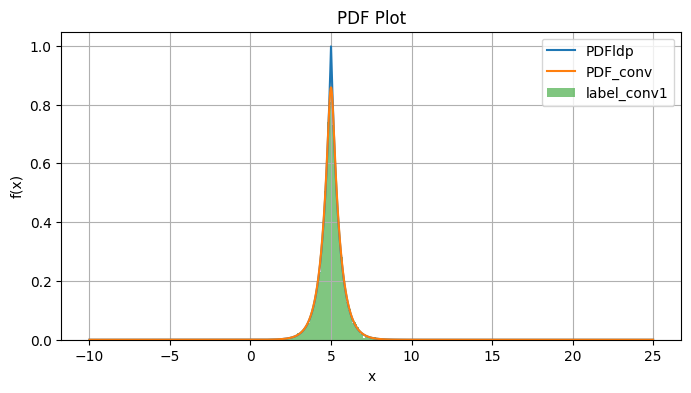

In [46]:
plot_pdf()

In [ ]:
f_LDP_func(x_b, 0.5, 1, 1, 6, torch.float32)